# Import Libraries and Data

In this analysis I use data for PXA trades over a 3 month period from October 15, 2024 to Jan 15, 2025 and limit order book data at 1 second intervals on the day of Jan 15, 2025. I will use this data to help me create a trading strategy.

I choose 1 second limit order book data because I want to have a snapshot of the order book at each point before a trade occurred. 1 second is the shortest time frame and will provide the most recent snapshot of the order book before a trade occurred. The alternative option was 1 minute intervals but that snapshot could be slightly delayed or not as precise. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings("ignore")
from datetime import datetime, time

In [3]:
# Import Trades Data
trades = pd.read_csv("AU STK PXA.X 20241015-20250115 Trades.csv")

trades['Date-Time'] = pd.to_datetime(trades['Date-Time'])
trades['Time'] = trades['Date-Time'].dt.time

print(trades.shape)
trades.head()

(270733, 24)


,#RIC,Alias Underlying RIC,Domain,Date-Time,Type,Price,Volume,Market VWAP,Buyer ID,Bid Price,...,Qualifiers,Exch Time,Date,Tick Dir.,Open,High,Low,Turnover,Unique Trade Identification,Time
0,PXA.CHA,NaN,Market Price,2024-10-15 05:00:01.939683177+11:00,Mkt. Condition,NaN,NaN,NaN,NaN,NaN,...,C[PERIOD_CD2];CLS[PRC_QL_CD];C [INST_PHASE],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,05:00:01.939683
1,PXA.CHA,NaN,Market Price,2024-10-15 06:35:00.144596729+11:00,Mkt. Condition,NaN,NaN,NaN,NaN,NaN,...,A[PERIOD_CD2]; [PRC_QL_CD];PET[INST_PHASE],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06:35:00.144596
2,PXA.AX,NaN,Market Price,2024-10-15 07:00:02.055942553+11:00,Mkt. Condition,NaN,NaN,NaN,NaN,NaN,...,POP[PRC_QL_CD],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07:00:02.055942
3,PXA.CHA,NaN,Market Price,2024-10-15 10:00:00.129991262+11:00,Mkt. Condition,NaN,NaN,NaN,NaN,NaN,...,T[PERIOD_CD2]; [PRC_QL_CD];T [INST_PHASE],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10:00:00.129991
4,PXA.AX,NaN,Market Price,2024-10-15 10:06:44.151039660+11:00,Mkt. Condition,NaN,NaN,NaN,NaN,NaN,...,OPN[PRC_QL_CD],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10:06:44.151039


In [32]:
# Import Limit Order Book Data

lob = pd.read_csv("AU STK PXA.X 20250115 Intraday 1Sec.csv")
lob["Date-Time"] = pd.to_datetime(lob["Date-Time"])
specificcols = ["#RIC", "Date-Time", "Close Bid", "Close Ask", "Close Bid Size", "Close Ask Size", "Close Mid Price"]
print(lob.shape)
print(lob.columns)
lob[specificcols].head()

(172798, 33)
Index(['#RIC', 'Alias Underlying RIC', 'Domain', 'Date-Time', 'Type', 'Open',
       'High', 'Low', 'Last', 'Volume', 'No. Trades', 'Open Bid', 'High Bid',
       'Low Bid', 'Close Bid', 'No. Bids', 'Open Ask', 'High Ask', 'Low Ask',
       'Close Ask', 'No. Asks', 'Open Bid Size', 'High Bid Size',
       'Low Bid Size', 'Close Bid Size', 'Open Ask Size', 'High Ask Size',
       'Low Ask Size', 'Close Ask Size', 'Open Mid Price', 'High Mid Price',
       'Low Mid Price', 'Close Mid Price'],
      dtype='object')


,#RIC,Date-Time,Close Bid,Close Ask,Close Bid Size,Close Ask Size,Close Mid Price
0,PXA.AX,2025-01-15 00:00:00+11:00,12.68,13.02,2208,950,NaN
1,PXA.CHA,2025-01-15 00:00:00+11:00,12.85,12.97,9,76,NaN
2,PXA.AX,2025-01-15 00:00:01+11:00,12.68,13.02,2208,950,NaN
3,PXA.CHA,2025-01-15 00:00:01+11:00,12.85,12.97,9,76,NaN
4,PXA.AX,2025-01-15 00:00:02+11:00,12.68,13.02,2208,950,NaN


# Preprocessing

To preprocess the data, I first filter the trades data to the specific day of Jan 15, 2025. This is the day for which I will construct a trading strategy.

I then, filter the trades on this day by time to fit within trading hours of 10:10am to 4pm AEST (GMT+11). 10:10am is used as a time stamp post the initial opening auction. Trading hours end at 4pm before the closing auction.

I also calculate the Value Traded and then the Cumulative Volume Weighted Average Price throughout the day.

In [83]:
# onedaytrades = trades[trades['Date-Time'].dt.date == pd.to_datetime('2024-01-15').date()]
import datetime
alltrades = trades[trades['Date-Time'].dt.date == pd.to_datetime('2025-01-14').date()]

# Filter trades by time
start_time = time(10, 10, 0)  # 10:10:00 AM
end_time = time(16, 0, 0)     # 16:00:00 PM
alltrades = alltrades[alltrades['Time'] >= start_time]
alltrades = alltrades[alltrades["Time"] <= end_time]
alltrades = alltrades.sort_values(by="Time")

# Value Traded
alltrades["Value Traded"] = alltrades["Price"] * alltrades["Volume"]

# VWAP
alltrades["Cumulative Value Traded"] = alltrades["Value Traded"].cumsum()
alltrades["Cumulative Volume"] = alltrades["Volume"].cumsum()
alltrades["Cumulative VWAP"] = alltrades["Cumulative Value Traded"] / alltrades["Cumulative Volume"]

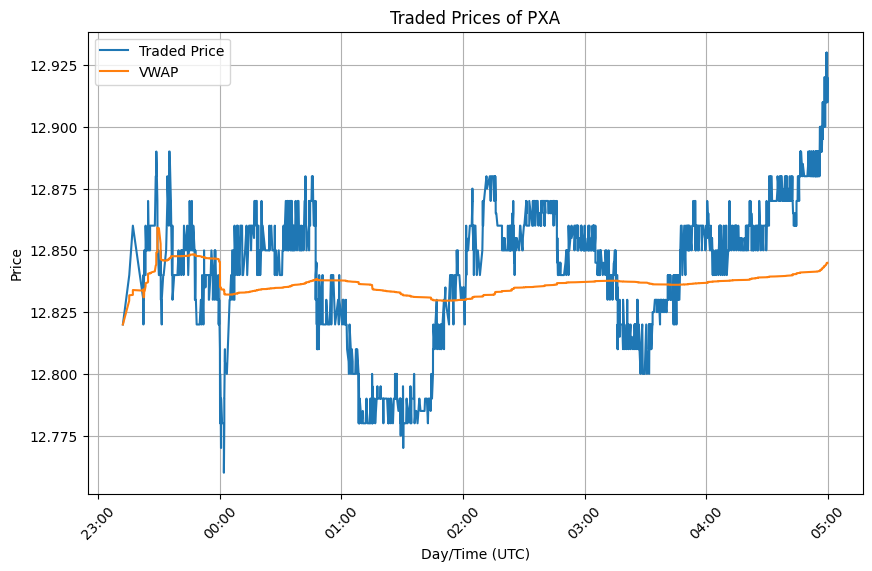

In [84]:
import matplotlib.dates as mdates

plt.figure(figsize=(10,6))
plt.plot(alltrades['Date-Time'], alltrades['Price'], label = "Traded Price");
plt.plot(alltrades['Date-Time'], alltrades['Cumulative VWAP'], label = "VWAP");

# # Format x-axis labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format as HH:MM
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Show every hour

plt.xticks(rotation=45)
plt.xlabel("Day/Time (UTC)")
plt.ylabel("Price")

plt.grid(True)
plt.legend()

plt.title("Traded Prices of PXA");

In [19]:
onedaytrades = trades[trades['Date-Time'].dt.date == pd.to_datetime('2025-01-15').date()]

# Filter trades by time
start_time = time(10, 10, 0)  # 10:10:00 AM
end_time = time(16, 0, 0)     # 16:00:00 PM
onedaytimetrades = onedaytrades[onedaytrades['Time'] >= start_time]
onedaytimetrades = onedaytimetrades[onedaytimetrades["Time"] <= end_time]
onedaytimetrades = onedaytimetrades.sort_values(by="Time")

# Value Traded
onedaytimetrades["Value Traded"] = onedaytimetrades["Price"] * onedaytimetrades["Volume"]

# VWAP
onedaytimetrades["Cumulative Value Traded"] = onedaytimetrades["Value Traded"].cumsum()
onedaytimetrades["Cumulative Volume"] = onedaytimetrades["Volume"].cumsum()
onedaytimetrades["Cumulative VWAP"] = onedaytimetrades["Cumulative Value Traded"] / onedaytimetrades["Cumulative Volume"]


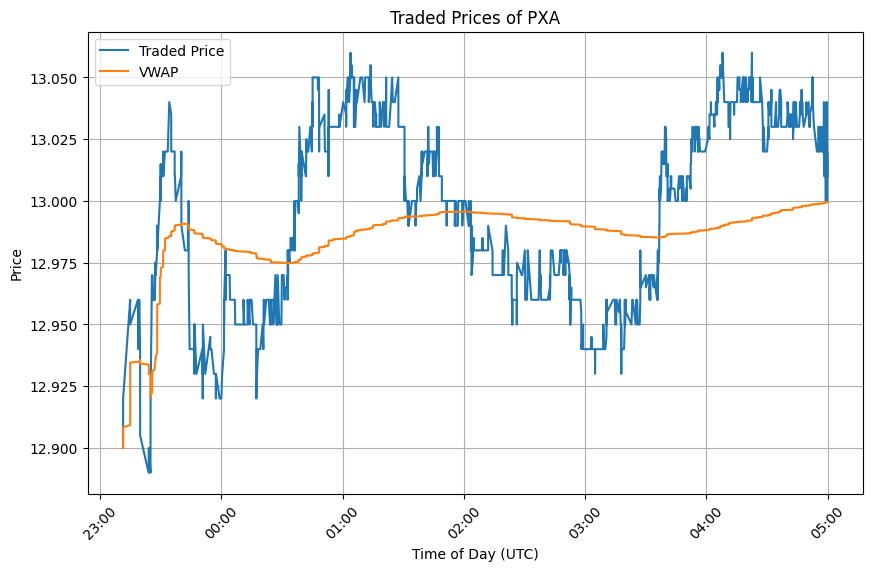

In [20]:
import matplotlib.dates as mdates

plt.figure(figsize=(10,6))
plt.plot(onedaytimetrades['Date-Time'], onedaytimetrades['Price'], label = "Traded Price");
plt.plot(onedaytimetrades['Date-Time'], onedaytimetrades['Cumulative VWAP'], label = "VWAP");

# Format x-axis labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format as HH:MM
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Show every hour

plt.xticks(rotation=45)
plt.xlabel("Time of Day (UTC)")
plt.ylabel("Price")

plt.grid(True)
plt.legend()

plt.title("Traded Prices of PXA");

This plot provides us with a simple idea for a trade. Use the VWAP as a measure of the mean and you can trade a mean reversion strategy. Throughout the day, the price of the stock fluctuates above and below the VWAP. 

An opportunity to buy the stock occurs when the traded price falls below the VWAP and an opportunity to sell the stock occurs when the traded price goes above the VWAP.

Next, I merge the trades data with limit order book data to get a snapshot of the order book the instant before a trade was executed.

In [33]:
# Extracting time component only
lob['Date-Time'] = pd.to_datetime(lob['Date-Time'])
lob['Time'] = lob['Date-Time'].dt.time

# Filter trades by time
start_time = time(10, 10, 0)  # 10:10:00 AM
end_time = time(16, 0, 0)     # 16:00:00 PM
lob = lob[lob['Time'] >= start_time]
lob = lob[lob["Time"] <= end_time]
lob = lob.sort_values(by="Time")
lob = lob.reset_index()
lob["LOB_Index"] = lob.index
specificcols += ["LOB_Index"]
lob[specificcols].head()

,#RIC,Date-Time,Close Bid,Close Ask,Close Bid Size,Close Ask Size,Close Mid Price,LOB_Index
0,PXA.AX,2025-01-15 10:10:00+11:00,12.86,12.9,1204,64,NaN,0
1,PXA.CHA,2025-01-15 10:10:00+11:00,12.86,12.9,163,47,NaN,1
2,PXA.AX,2025-01-15 10:10:01+11:00,12.86,12.9,1204,64,NaN,2
3,PXA.CHA,2025-01-15 10:10:01+11:00,12.86,12.9,163,47,NaN,3
4,PXA.AX,2025-01-15 10:10:02+11:00,12.86,12.9,1204,64,NaN,4


In [34]:
# ✅ Find the most recent LOB entry before each trade using searchsorted
lob_timestamps = lob["Time"].values
trade_timestamps = onedaytimetrades["Time"].values

# Find the index of the most recent LOB entry before the trade
indices = lob_timestamps.searchsorted(trade_timestamps, side="right") - 1

# Assign corresponding LOB index to trades
onedaytimetrades["LOB_Index"] = indices

In [40]:
merged_to = pd.merge(onedaytimetrades, lob[specificcols], on="LOB_Index")
print(merged_to.shape)
print(merged_to.columns)
cols = ["Date-Time_x", "Time", "Price", "Volume", "Cumulative VWAP", "Close Bid", "Close Ask", "LOB_Index"]
merged_to[cols].head(5)

(4406, 36)
Index(['#RIC_x', 'Alias Underlying RIC', 'Domain', 'Date-Time_x', 'Type',
       'Price', 'Volume', 'Market VWAP', 'Buyer ID', 'Bid Price', 'Bid Size',
       'Seller ID', 'Ask Price', 'Ask Size', 'Qualifiers', 'Exch Time', 'Date',
       'Tick Dir.', 'Open', 'High', 'Low', 'Turnover',
       'Unique Trade Identification', 'Time', 'Value Traded',
       'Cumulative Value Traded', 'Cumulative Volume', 'Cumulative VWAP',
       'LOB_Index', '#RIC_y', 'Date-Time_y', 'Close Bid', 'Close Ask',
       'Close Bid Size', 'Close Ask Size', 'Close Mid Price'],
      dtype='object')


,Date-Time_x,Time,Price,Volume,Cumulative VWAP,Close Bid,Close Ask,LOB_Index
0,2025-01-15 10:11:15.760473307+11:00,10:11:15.760473,12.90,14.0,12.900000,12.87,12.91,151
1,2025-01-15 10:11:21.484570847+11:00,10:11:21.484570,12.90,23.0,12.900000,12.91,12.92,163
2,2025-01-15 10:11:21.484570847+11:00,10:11:21.484570,12.90,24.0,12.900000,12.91,12.92,163
3,2025-01-15 10:11:21.484570847+11:00,10:11:21.484570,12.90,10.0,12.900000,12.91,12.92,163
4,2025-01-15 10:11:21.485555418+11:00,10:11:21.485555,12.91,50.0,12.904132,12.91,12.92,163


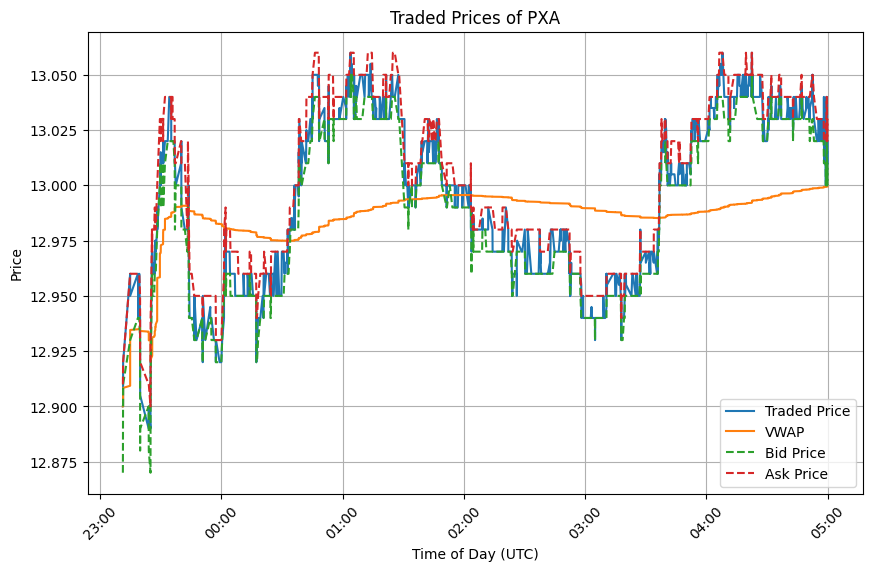

In [87]:
import matplotlib.dates as mdates

plt.figure(figsize=(10,6))
plt.plot(merged_to['Date-Time_x'], merged_to['Price'], label = "Traded Price");
plt.plot(merged_to['Date-Time_x'], merged_to['Cumulative VWAP'], label = "VWAP");

# Plot the Bid and Ask prices
plt.plot(merged_to['Date-Time_x'], merged_to['Close Bid'], label="Bid Price", linestyle='--')
plt.plot(merged_to['Date-Time_x'], merged_to['Close Ask'], label="Ask Price", linestyle='--')

# Format x-axis labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format as HH:MM
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Show every hour

plt.xticks(rotation=45)
plt.xlabel("Time of Day (UTC)")
plt.ylabel("Price")

plt.grid(True)
plt.legend()

plt.title("Traded Prices of PXA");

# Trade Criteria Analysis

In [49]:
# determining mean average deviation of traded price from VWAP
# this determines the trade exit criteria

merged_to["Absolute VWAP - Traded Price"] = abs(merged_to["Cumulative VWAP"] - merged_to["Price"])
merged_to["Absolute VWAP - Traded Price"].mean().item()

0.03210408462424319

In [125]:
# determine the position size

import math

position_size = math.ceil(df['Volume'].mean())
print("Position Size:", position_size)

Position Size: 31


In [120]:
merged_to["Spread"] = abs(merged_to["Close Ask"] - merged_to["Close Bid"])
merged_to["Spread"].mean().item()

0.01546300499319127

On average the Cumulative VWAP deviates a 3 cents from the traded price. This provides an opportunity to trade.

In [97]:
colsToUse = ["Date-Time_x", "Time", "Type", "Price", "Volume", "Cumulative VWAP", "Close Bid", "Close Ask", "Close Bid Size", "Close Ask Size"]
merged_to[colsToUse].head()

,Date-Time_x,Time,Type,Price,Volume,Cumulative VWAP,Close Bid,Close Ask,Close Bid Size,Close Ask Size
0,2025-01-15 10:11:15.760473307+11:00,10:11:15.760473,Trade,12.90,14.0,12.900000,12.87,12.91,754,226
1,2025-01-15 10:11:21.484570847+11:00,10:11:21.484570,Trade,12.90,23.0,12.900000,12.91,12.92,594,128
2,2025-01-15 10:11:21.484570847+11:00,10:11:21.484570,Trade,12.90,24.0,12.900000,12.91,12.92,594,128
3,2025-01-15 10:11:21.484570847+11:00,10:11:21.484570,Trade,12.90,10.0,12.900000,12.91,12.92,594,128
4,2025-01-15 10:11:21.485555418+11:00,10:11:21.485555,Trade,12.91,50.0,12.904132,12.91,12.92,594,128


#### Trading Strategy Implementation 1

This is a trading strategy implementation.

*  Entry Criteria: last traded price is 3 cents or more different from the cumulative VWAP. long entry if the traded price below the VWAP, short entry is the traded price is above the VWAP

*  Exit Criteria: take profits if the stock moves in the direction you want and you make 3 cents. stop loss if you lose 1 cent from the entry price.

*  Position Size: use the average trade volume to determine my position size. this comes out to 31 shares for every trade

*  Trade Execution: importantly, this implementation assumes that the trade occurs at the last traded price. this is in some ways an incorrect assumption and is corrected down below.


In [126]:
df = merged_to[colsToUse].copy()

# Define our trading parameters (in dollars)
profit_target = 0.03   # target profit of 3 cents
stop_loss = 0.01     # stop loss between 0.5 and 1 cent (here, 0.75 cent)

# Add a column for signals; we'll fill it with entry and exit instructions
df['Signal'] = ""

# Variables to track our current position
position = None  # will be 'long', 'short', or None (no open position)
entry_price = None

# Loop over the rows of the DataFrame
for idx, row in df.iterrows():
    price = row['Price']
    vwap = row['Cumulative VWAP']
    
    # If we are not in a position, check for an entry signal.
    if position is None:
        # Long entry: traded price is at least 3 cents below cumulative VWAP.
        if (vwap - price) >= profit_target:
            position = 'long'
            entry_price = price
            df.at[idx, 'Signal'] = f"buy entry, {position_size} shares @ {price:.4f}"
        # Short entry: traded price is at least 3 cents above cumulative VWAP.
        elif (price - vwap) >= profit_target:
            position = 'short'
            entry_price = price
            df.at[idx, 'Signal'] = f"sell entry, {position_size} shares @ {price:.4f}"
    
    # If we have an open long position, check for exit conditions.
    elif position == 'long':
        # Profit target hit: price has increased by at least 3 cents.
        if (price - entry_price) >= profit_target:
            df.at[idx, 'Signal'] = f"exit, {position_size} shares @ {price:.4f}"
            position = None
            entry_price = None
        # Stop loss hit: price has fallen by the stop_loss amount.
        elif (entry_price - price) >= stop_loss:
            df.at[idx, 'Signal'] = f"exit, {position_size} shares @ {price:.4f}"
            position = None
            entry_price = None
    
    # If we have an open short position, check for exit conditions.
    elif position == 'short':
        # Profit target hit: price has fallen by at least 3 cents relative to entry.
        if (entry_price - price) >= profit_target:
            df.at[idx, 'Signal'] = f"exit, {position_size} shares @ {price:.4f}"
            position = None
            entry_price = None
        # Stop loss hit: price has risen by the stop_loss amount relative to entry.
        elif (price - entry_price) >= stop_loss:
            df.at[idx, 'Signal'] = f"exit, {position_size} shares @ {price:.4f}"
            position = None
            entry_price = None

df[df['Signal']!=""][["Price", "Cumulative VWAP", "Signal"]].head(20)

,Price,Cumulative VWAP,Signal
15,12.960,12.909342,"sell entry, 31 shares @ 12.9600"
37,12.930,12.935553,"exit, 31 shares @ 12.9300"
46,12.890,12.933853,"buy entry, 31 shares @ 12.8900"
73,12.940,12.921761,"exit, 31 shares @ 12.9400"
74,12.970,12.922539,"sell entry, 31 shares @ 12.9700"
120,12.990,12.957086,"exit, 31 shares @ 12.9900"
126,13.000,12.958409,"sell entry, 31 shares @ 13.0000"
137,13.015,12.969490,"exit, 31 shares @ 13.0150"
138,13.015,12.969663,"sell entry, 31 shares @ 13.0150"
198,13.040,12.985597,"exit, 31 shares @ 13.0400"


In [127]:


# Create an empty list to store each trade's data.
trades = []
current_trade = {}

for idx, row in df.iterrows():
    signal = row['Signal']
    # Skip if the signal is empty or NaN.
    if pd.isna(signal) or signal.strip() == "":
        continue

    # If the signal is an entry signal.
    if "entry" in signal.lower():
        # Expected format: "buy entry, 31 shares @ 12.9500" or "sell entry, 31 shares @ 12.9500"
        parts = signal.split(',')
        entry_type = parts[0].strip()  # e.g., "buy entry" or "sell entry"
        # Determine the trade side.
        trade_side = "long" if "buy" in entry_type.lower() else "short"

        # Parse the second part for shares and price.
        # e.g., "31 shares @ 12.9500"
        second_part = parts[1].strip()
        shares_str = second_part.split("shares")[0].strip()  # "31"
        shares = int(shares_str)
        price_str = second_part.split("@")[1].strip()  # "12.9500"
        entry_price = float(price_str)

        # Begin a new trade record.
        current_trade = {
            "side": trade_side,
            "shares": shares,
            "entry_price": entry_price,
            "entry_idx": idx
        }

    # If the signal is an exit signal.
    elif "exit" in signal.lower():
        # Expected format: "exit, 31 shares @ 12.9800"
        if not current_trade:
            # If there's no active trade, skip this exit.
            continue

        parts = signal.split(',')
        second_part = parts[1].strip()
        shares_str = second_part.split("shares")[0].strip()  # e.g., "31"
        shares_exit = int(shares_str)
        price_str = second_part.split("@")[1].strip()  # e.g., "12.9800"
        exit_price = float(price_str)

        # Optional: Check that shares match the entry.
        if shares_exit != current_trade["shares"]:
            print(f"Warning: Trade at index {idx} has mismatched shares.")
        
        # Complete the trade record.
        current_trade["exit_price"] = exit_price
        current_trade["exit_idx"] = idx

        # Calculate profit: for long, profit = (exit_price - entry_price) * shares;
        # for short, profit = (entry_price - exit_price) * shares.
        if current_trade["side"] == "long":
            profit = (exit_price - current_trade["entry_price"]) * current_trade["shares"]
        else:
            profit = (current_trade["entry_price"] - exit_price) * current_trade["shares"]
        current_trade["profit"] = profit

        trades.append(current_trade)
        current_trade = {}  # Reset for the next trade

# Convert the list of trades into a DataFrame for easier metric calculations.
trades_df = pd.DataFrame(trades)

# Calculate total traded notional amount.
# We use the entry price multiplied by the number of shares to represent the capital allocated per trade.
trades_df["notional"] = trades_df["entry_price"] * trades_df["shares"]
total_amount_traded = trades_df["notional"].sum()

# Calculate total profit made.
total_profit = trades_df["profit"].sum()

# Percentage return relative to the total notional traded.
percentage_return = (total_profit / total_amount_traded) * 100 if total_amount_traded != 0 else 0

# Additional Metrics:
num_trades = len(trades_df)
average_profit_per_trade = trades_df["profit"].mean() if num_trades > 0 else 0
# Win rate: percentage of trades with a positive profit.
win_rate = (trades_df["profit"] > 0).mean() * 100 if num_trades > 0 else 0
max_profit = trades_df["profit"].max() if num_trades > 0 else None
max_loss = trades_df["profit"].min() if num_trades > 0 else None

# Print the metrics.
print("Total Amount Traded: ${:.2f}".format(total_amount_traded))
print("Total Profit: ${:.2f}".format(total_profit))
print("Percentage Return: {:.2f}%".format(percentage_return))
print("Number of Trades: {}".format(num_trades))
print("Average Profit per Trade: ${:.4f}".format(average_profit_per_trade))
print("Win Rate: {:.2f}%".format(win_rate))
print("Max Profit on a Trade: ${:.2f}".format(max_profit) if max_profit is not None else "N/A")
print("Max Loss on a Trade: ${:.2f}".format(max_loss) if max_loss is not None else "N/A")


Total Amount Traded: $13286.14
Total Profit: $3.72
Percentage Return: 0.03%
Number of Trades: 33
Average Profit per Trade: $0.1127
Win Rate: 39.39%
Max Profit on a Trade: $1.55
Max Loss on a Trade: $-0.77


We see that this trading strategy has some potential but is not a great strategy. The win rate is about 40% out of 33 total trades made throughout the day. The max profit on a trade is $1.55 and the max loss on a trade is $0.77. While not having significantly high returns, with the stop loss this strategy somewhat caps losses as well.

One important consideration is that the transaction cost of crossing the spread is not considered here. Long entries should generally take place at the ask price and short entries should take place at the bid price. I have not yet added that in and I believe that whatever small profits I have currently will be eroded away once I add that in.

#### Trading Strategy Implementation 2

This is a trading strategy implementation.

*  Entry Criteria: last traded price is 3 cents or more different from the cumulative VWAP. long entry if the traded price below the VWAP, short entry is the traded price is above the VWAP

*  Exit Criteria: take profits if the stock moves in the direction you want and you make 3 cents. stop loss if you lose 1 cent from the entry price.

*  Position Size: use the average trade volume to determine my position size. this comes out to 31 shares for every trade

*  Trade Execution: importantly, this implementation assumes that the trade occurs at the market price as if I am a prop trader crossing the spread. I pay the transaction costs to cross the spread. Long entries should generally take place at the ask price and short entries should take place at the bid price.



In [139]:
df = merged_to[colsToUse].copy()

# Define our trading parameters (in dollars)
profit_target = 0.05   # target profit of 3 cents
stop_loss = 0.02       # stop loss of 1 cent (adjust as needed)

# Add a column for signals; we'll fill it with entry and exit instructions
df['Signal'] = ""

# Assume you have defined position_size somewhere in your code
# position_size = <your_position_size_value>

# Variables to track our current position
position = None  # 'long', 'short', or None
entry_price = None

# Loop over the rows of the DataFrame
for idx, row in df.iterrows():
    price = row['Price']
    vwap = row['Cumulative VWAP']
    bid = row["Close Bid"]
    ask = row["Close Ask"] 
    
    # If not in a position, check for an entry signal.
    if position is None:
        # Long entry: traded price is at least 3 cents below cumulative VWAP.
        if (vwap - ask) >= profit_target:
            position = 'long'
            entry_price = ask  # you'll buy at the ask price
            df.at[idx, 'Signal'] = f"buy entry, {position_size} shares @ {entry_price:.4f}"
        # Short entry: traded price is at least 3 cents above cumulative VWAP.
        elif (bid - vwap) >= profit_target:
            position = 'short'
            entry_price = bid  # you'll sell at the bid price
            df.at[idx, 'Signal'] = f"sell entry, {position_size} shares @ {entry_price:.4f}"
    
    # If in a long position, check exit conditions.
    elif position == 'long':
        # Profit target: exit if bid has increased enough from the ask entry.
        if (bid - entry_price) >= profit_target:
            df.at[idx, 'Signal'] = f"exit, {position_size} shares @ {bid:.4f}"
            position = None
            entry_price = None
        # Stop loss: exit if bid has fallen such that the loss reaches the stop loss.
        elif (entry_price - bid) >= stop_loss:
            df.at[idx, 'Signal'] = f"exit, {position_size} shares @ {bid:.4f}"
            position = None
            entry_price = None
    
    # If in a short position, check exit conditions.
    elif position == 'short':
        # Profit target: exit if ask has fallen enough from the bid entry.
        if (entry_price - ask) >= profit_target:
            df.at[idx, 'Signal'] = f"exit, {position_size} shares @ {ask:.4f}"
            position = None
            entry_price = None
        # Stop loss: exit if ask has risen such that the loss reaches the stop loss.
        elif (ask - entry_price) >= stop_loss:
            df.at[idx, 'Signal'] = f"exit, {position_size} shares @ {ask:.4f}"
            position = None
            entry_price = None

# Show a sample of the resulting signals
df[df['Signal'] != ""][["Price", "Cumulative VWAP", "Close Bid", "Close Ask", "Signal"]].head(20)


,Price,Cumulative VWAP,Close Bid,Close Ask,Signal
473,12.92,12.983109,12.92,12.93,"buy entry, 31 shares @ 12.9300"
949,12.98,12.974919,12.98,12.99,"exit, 31 shares @ 12.9800"
1104,13.04,12.978240,13.03,13.05,"sell entry, 31 shares @ 13.0300"
1105,13.04,12.978271,13.03,13.05,"exit, 31 shares @ 13.0500"
1106,13.04,12.978274,13.03,13.05,"sell entry, 31 shares @ 13.0300"
1107,13.04,12.978296,13.03,13.05,"exit, 31 shares @ 13.0500"
1108,13.04,12.978332,13.03,13.05,"sell entry, 31 shares @ 13.0300"
1109,13.04,12.978533,13.03,13.05,"exit, 31 shares @ 13.0500"
1110,13.04,12.978535,13.03,13.05,"sell entry, 31 shares @ 13.0300"
1111,13.03,12.978541,13.03,13.05,"exit, 31 shares @ 13.0500"


In [140]:


# Create an empty list to store each trade's data.
trades = []
current_trade = {}

for idx, row in df.iterrows():
    signal = row['Signal']
    # Skip if the signal is empty or NaN.
    if pd.isna(signal) or signal.strip() == "":
        continue

    # If the signal is an entry signal.
    if "entry" in signal.lower():
        # Expected format: "buy entry, 31 shares @ 12.9500" or "sell entry, 31 shares @ 12.9500"
        parts = signal.split(',')
        entry_type = parts[0].strip()  # e.g., "buy entry" or "sell entry"
        # Determine the trade side.
        trade_side = "long" if "buy" in entry_type.lower() else "short"

        # Parse the second part for shares and price.
        # e.g., "31 shares @ 12.9500"
        second_part = parts[1].strip()
        shares_str = second_part.split("shares")[0].strip()  # "31"
        shares = int(shares_str)
        price_str = second_part.split("@")[1].strip()  # "12.9500"
        entry_price = float(price_str)

        # Begin a new trade record.
        current_trade = {
            "side": trade_side,
            "shares": shares,
            "entry_price": entry_price,
            "entry_idx": idx
        }

    # If the signal is an exit signal.
    elif "exit" in signal.lower():
        # Expected format: "exit, 31 shares @ 12.9800"
        if not current_trade:
            # If there's no active trade, skip this exit.
            continue

        parts = signal.split(',')
        second_part = parts[1].strip()
        shares_str = second_part.split("shares")[0].strip()  # e.g., "31"
        shares_exit = int(shares_str)
        price_str = second_part.split("@")[1].strip()  # e.g., "12.9800"
        exit_price = float(price_str)

        # Optional: Check that shares match the entry.
        if shares_exit != current_trade["shares"]:
            print(f"Warning: Trade at index {idx} has mismatched shares.")
        
        # Complete the trade record.
        current_trade["exit_price"] = exit_price
        current_trade["exit_idx"] = idx

        # Calculate profit: for long, profit = (exit_price - entry_price) * shares;
        # for short, profit = (entry_price - exit_price) * shares.
        if current_trade["side"] == "long":
            profit = (exit_price - current_trade["entry_price"]) * current_trade["shares"]
        else:
            profit = (current_trade["entry_price"] - exit_price) * current_trade["shares"]
        current_trade["profit"] = profit

        trades.append(current_trade)
        current_trade = {}  # Reset for the next trade

# Convert the list of trades into a DataFrame for easier metric calculations.
trades_df = pd.DataFrame(trades)

# Calculate total traded notional amount.
# We use the entry price multiplied by the number of shares to represent the capital allocated per trade.
trades_df["notional"] = trades_df["entry_price"] * trades_df["shares"]
total_amount_traded = trades_df["notional"].sum()

# Calculate total profit made.
total_profit = trades_df["profit"].sum()

# Percentage return relative to the total notional traded.
percentage_return = (total_profit / total_amount_traded) * 100 if total_amount_traded != 0 else 0

# Additional Metrics:
num_trades = len(trades_df)
average_profit_per_trade = trades_df["profit"].mean() if num_trades > 0 else 0
# Win rate: percentage of trades with a positive profit.
win_rate = (trades_df["profit"] > 0).mean() * 100 if num_trades > 0 else 0
max_profit = trades_df["profit"].max() if num_trades > 0 else None
max_loss = trades_df["profit"].min() if num_trades > 0 else None

# Print the metrics.
print("Total Amount Traded: ${:.2f}".format(total_amount_traded))
print("Total Profit: ${:.2f}".format(total_profit))
print("Percentage Return: {:.2f}%".format(percentage_return))
print("Number of Trades: {}".format(num_trades))
print("Average Profit per Trade: ${:.4f}".format(average_profit_per_trade))
print("Win Rate: {:.2f}%".format(win_rate))
print("Max Profit on a Trade: ${:.2f}".format(max_profit) if max_profit is not None else "N/A")
print("Max Loss on a Trade: ${:.2f}".format(max_loss) if max_loss is not None else "N/A")


Total Amount Traded: $14951.30
Total Profit: $-18.91
Percentage Return: -0.13%
Number of Trades: 37
Average Profit per Trade: $-0.5111
Win Rate: 5.41%
Max Profit on a Trade: $1.55
Max Loss on a Trade: $-0.93
